In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Resnet50

In [5]:
from torchvision.models import resnet50

In [6]:
model = resnet50(pretrained=False)

# modify first conv with in_depth = 1 (grayscale images)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

# modify output of model to 7 classes
model.fc = nn.Linear(in_features=2048, out_features=7, bias=True)

model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
device = torch.device('cuda')
model = model.to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './resnet50_wo_tf.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6521925926208496 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 2.061 | Avg.acc: 0.239



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.787 | Avg. val_acc: 0.278
* Update optimal model
Epoch:  2


Loss=1.556823492050171 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 1.701 | Avg.acc: 0.315


- Avg. val_loss: 1.581 | Avg. val_acc: 0.387


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.3872345685958862 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

- Avg.loss: 1.561 | Avg.acc: 0.387


- Avg. val_loss: 1.457 | Avg. val_acc: 0.439


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.3616691827774048 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 1.448 | Avg.acc: 0.439


- Avg. val_loss: 1.430 | Avg. val_acc: 0.444


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.7715457677841187 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 1.390 | Avg.acc: 0.463


- Avg. val_loss: 1.388 | Avg. val_acc: 0.459


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.3229790925979614 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:33<00:00,  6.80it/s]

- Avg.loss: 1.352 | Avg.acc: 0.482


- Avg. val_loss: 1.316 | Avg. val_acc: 0.499


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.424750804901123 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.328 | Avg.acc: 0.492



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.321 | Avg. val_acc: 0.496
Epoch:  8


Loss=1.4557746648788452 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.301 | Avg.acc: 0.504


- Avg. val_loss: 1.280 | Avg. val_acc: 0.508


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.300339937210083 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.287 | Avg.acc: 0.509


- Avg. val_loss: 1.247 | Avg. val_acc: 0.521


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.4648983478546143 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.267 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.504
Epoch:  11


Loss=1.1002483367919922 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.261 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.285 | Avg. val_acc: 0.511
Epoch:  12


Loss=1.181145429611206 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:33<00:00,  6.79it/s]

- Avg.loss: 1.251 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.401 | Avg. val_acc: 0.480
Epoch:  13


Loss=1.1291248798370361 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]

- Avg.loss: 1.249 | Avg.acc: 0.524


- Avg. val_loss: 1.218 | Avg. val_acc: 0.549


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.2455607652664185 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.233 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.253 | Avg. val_acc: 0.535
Epoch:  15


Loss=1.3016903400421143 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 1.222 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.542
Epoch:  16


Loss=1.2431029081344604 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:33<00:00,  6.82it/s]

- Avg.loss: 1.226 | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.256 | Avg. val_acc: 0.522
Epoch:  17


Loss=1.3641963005065918 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]

- Avg.loss: 1.215 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.511
Epoch:  18


Loss=1.0612207651138306 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.206 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.272 | Avg. val_acc: 0.529
Epoch:  19


Loss=1.1762454509735107 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 1.201 | Avg.acc: 0.543



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.259 | Avg. val_acc: 0.519
Epoch:  20


Loss=1.6365833282470703 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.195 | Avg.acc: 0.546


- Avg. val_loss: 1.199 | Avg. val_acc: 0.556


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.2283179759979248 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.195 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.218 | Avg. val_acc: 0.542
Epoch:  22


Loss=1.2873926162719727 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.184 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.545
Epoch:  23


Loss=1.2043415307998657 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.189 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.187 | Avg. val_acc: 0.545
Epoch:  24


Loss=1.1109471321105957 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 1.180 | Avg.acc: 0.551


- Avg. val_loss: 1.166 | Avg. val_acc: 0.562


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.202621579170227 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.174 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192 | Avg. val_acc: 0.555
Epoch:  26


Loss=1.2080563306808472 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.172 | Avg.acc: 0.558


- Avg. val_loss: 1.167 | Avg. val_acc: 0.563


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.1518834829330444 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.170 | Avg.acc: 0.557


- Avg. val_loss: 1.156 | Avg. val_acc: 0.565


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.9931809902191162 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 1.163 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.560
Epoch:  29


Loss=1.0472455024719238 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.159 | Avg.acc: 0.560


- Avg. val_loss: 1.157 | Avg. val_acc: 0.566


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=0.9574896097183228 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.158 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.563
Epoch:  31


Loss=1.249966025352478 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.158 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.561
Epoch:  32


Loss=1.2696107625961304 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:33<00:00,  6.82it/s]

- Avg.loss: 1.151 | Avg.acc: 0.564


- Avg. val_loss: 1.122 | Avg. val_acc: 0.573


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=0.8911983370780945 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.141 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.379 | Avg. val_acc: 0.500
Epoch:  34


Loss=1.193191647529602 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.141 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.563
Epoch:  35


Loss=1.0625532865524292 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 1.143 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.243 | Avg. val_acc: 0.524
Epoch:  36


Loss=1.1400399208068848 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.136 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.252 | Avg. val_acc: 0.533
Epoch:  37


Loss=1.0877681970596313 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 1.134 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.160 | Avg. val_acc: 0.560
Epoch:  38


Loss=0.8825463056564331 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.135 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.284 | Avg. val_acc: 0.535
Epoch:  39


Loss=1.244897723197937 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.129 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.573
Epoch:  40


Loss=1.1268680095672607 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.125 | Avg.acc: 0.574


- Avg. val_loss: 1.132 | Avg. val_acc: 0.576
Epoch    40: reducing learning rate of group 0 to 2.0000e-03.


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=1.1470668315887451 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.076 | Avg.acc: 0.592


- Avg. val_loss: 1.100 | Avg. val_acc: 0.590


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=1.144410490989685 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.064 | Avg.acc: 0.598


- Avg. val_loss: 1.043 | Avg. val_acc: 0.598


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=1.267151117324829 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 1.054 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.586
Epoch:  44


Loss=1.1191868782043457 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 1.051 | Avg.acc: 0.599


- Avg. val_loss: 1.065 | Avg. val_acc: 0.603


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=1.4969440698623657 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 1.044 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.591
Epoch:  46


Loss=1.1250766515731812 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 1.044 | Avg.acc: 0.605


- Avg. val_loss: 1.067 | Avg. val_acc: 0.612


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  47


Loss=0.8861181139945984 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.040 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.598
Epoch:  48


Loss=0.9423348903656006 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.042 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.599
Epoch:  49


Loss=1.1226654052734375 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.040 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.596
Epoch:  50


Loss=0.8606663942337036 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 1.033 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.599
Epoch    50: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  51


Loss=1.123121976852417 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.997 | Avg.acc: 0.625


- Avg. val_loss: 1.027 | Avg. val_acc: 0.612


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  52


Loss=1.0333071947097778 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.986 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.607
Epoch:  53


Loss=0.9369392395019531 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.976 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.605
Epoch:  54


Loss=1.2186810970306396 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 0.972 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.612
Epoch:  55


Loss=1.2777578830718994 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

- Avg.loss: 0.967 | Avg.acc: 0.633


- Avg. val_loss: 1.036 | Avg. val_acc: 0.613


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=0.8764655590057373 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 0.963 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.613
Epoch:  57


Loss=0.8058693408966064 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.958 | Avg.acc: 0.637


- Avg. val_loss: 1.020 | Avg. val_acc: 0.615


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  58


Loss=0.7884163856506348 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.956 | Avg.acc: 0.640


- Avg. val_loss: 1.034 | Avg. val_acc: 0.618


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=0.8482174873352051 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.957 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.611
Epoch:  60


Loss=0.812201738357544 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.949 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.609
Epoch:  61


Loss=0.7731052041053772 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.949 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.600
Epoch:  62


Loss=0.9402580261230469 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.947 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.614
Epoch:  63


Loss=1.1676967144012451 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.947 | Avg.acc: 0.641


- Avg. val_loss: 1.016 | Avg. val_acc: 0.619


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  64


Loss=0.7940168976783752 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.938 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.608
Epoch:  65


Loss=1.0044962167739868 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 0.936 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.618
Epoch:  66


Loss=0.8577969074249268 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.934 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.613
Epoch:  67


Loss=0.8757537603378296 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.938 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.614
Epoch:  68


Loss=0.7669557332992554 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.926 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.615
Epoch:  69


Loss=1.1031887531280518 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.928 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.615
Epoch:  70


Loss=0.8642070293426514 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 0.925 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.619
Epoch:  71


Loss=1.0180085897445679 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.919 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.619
Epoch    71: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  72


Loss=1.0173510313034058 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.900 | Avg.acc: 0.659


- Avg. val_loss: 1.015 | Avg. val_acc: 0.622


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  73


Loss=0.9732412099838257 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.892 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.616
Epoch:  74


Loss=0.8411904573440552 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.877 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.620
Epoch:  75


Loss=1.1269264221191406 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.875 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.621
Epoch:  76


Loss=0.7748079895973206 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.876 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.619
Epoch:  77


Loss=0.7938107252120972 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.872 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.622
Epoch:  78


Loss=0.8875789046287537 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.871 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.621
Epoch:  79


Loss=1.0029561519622803 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.863 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.619
Epoch:  80


Loss=0.719273567199707 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.862 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.622
Epoch:  81


Loss=0.8474611639976501 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.860 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.620
Epoch:  82


Loss=1.0657440423965454 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]

- Avg.loss: 0.859 | Avg.acc: 0.678


- Avg. val_loss: 1.026 | Avg. val_acc: 0.624


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  83


Loss=0.8781682848930359 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.849 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.621
Epoch:  84


Loss=1.0368578433990479 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.857 | Avg.acc: 0.678


- Avg. val_loss: 1.011 | Avg. val_acc: 0.625


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  85


Loss=1.0661324262619019 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]

- Avg.loss: 0.849 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.620
Epoch    85: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  86


Loss=1.091813564300537 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.829 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.623
Epoch:  87


Loss=0.8780219554901123 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]

- Avg.loss: 0.825 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.624
Epoch:  88


Loss=0.8449019193649292 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.825 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.617
Epoch:  89


Loss=1.051184892654419 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.821 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.622
Epoch:  90


Loss=0.9067766070365906 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.812 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.618
Epoch:  91


Loss=0.9784553050994873 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.811 | Avg.acc: 0.695


- Avg. val_loss: 1.020 | Avg. val_acc: 0.628


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  92


Loss=0.7942401766777039 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.810 | Avg.acc: 0.695


- Avg. val_loss: 1.023 | Avg. val_acc: 0.629


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  93


Loss=0.5476388931274414 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.808 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.627
Epoch    93: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  94


Loss=0.7163222432136536 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.803 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.624
Epoch:  95


Loss=0.7463652491569519 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.793 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.627
Epoch:  96


Loss=0.8983661532402039 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.795 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.621
Epoch:  97


Loss=0.661162257194519 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.793 | Avg.acc: 0.703


- Avg. val_loss: 1.022 | Avg. val_acc: 0.629


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  98


Loss=0.8646931648254395 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

- Avg.loss: 0.791 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.627
Epoch:  99


Loss=1.1553325653076172 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 0.788 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.627
Epoch:  100


Loss=0.5751495957374573 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 0.790 | Avg.acc: 0.703


- Avg. val_loss: 1.029 | Avg. val_acc: 0.624
Finished Training


([<matplotlib.lines.Line2D at 0x7f56dfb3a358>,
 0.6294232376706603)

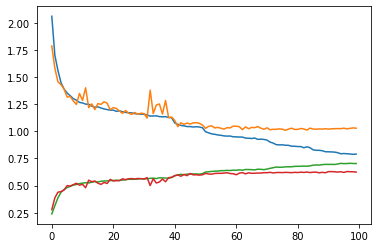

In [9]:
import pickle
pickle.dump(hist, open('resnet50_wo_tf_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
test_model = torch.load('resnet50_wo_tf.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.001 | Avg. val_acc: 0.636


## VGG-16

In [5]:
from torchvision.models import vgg16

In [6]:
model = vgg16(pretrained=False)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.classifier[-1] = nn.Linear(in_features=4096, out_features=7, bias=True)
model

for param in model.parameters():
    param.requires_grad = True

In [7]:
device = torch.device('cuda')
model = model.to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './vgg16_bn_wo_tf.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6821179389953613 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:33<00:00,  6.75it/s]

- Avg.loss: 2.051 | Avg.acc: 0.252


- Avg. val_loss: 1.725 | Avg. val_acc: 0.294


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.7396924495697021 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]

- Avg.loss: 1.617 | Avg.acc: 0.343


- Avg. val_loss: 1.489 | Avg. val_acc: 0.408


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.4142801761627197 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:33<00:00,  6.66it/s]

- Avg.loss: 1.440 | Avg.acc: 0.432


- Avg. val_loss: 1.514 | Avg. val_acc: 0.415


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.555154800415039 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]

- Avg.loss: 1.344 | Avg.acc: 0.480


- Avg. val_loss: 1.337 | Avg. val_acc: 0.485


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.1939716339111328 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 1.304 | Avg.acc: 0.501



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.467
Epoch:  6


Loss=1.3400425910949707 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 1.261 | Avg.acc: 0.519


- Avg. val_loss: 1.278 | Avg. val_acc: 0.500


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2924996614456177 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 1.240 | Avg.acc: 0.528


- Avg. val_loss: 1.280 | Avg. val_acc: 0.521


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.2635371685028076 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 1.215 | Avg.acc: 0.541


- Avg. val_loss: 1.202 | Avg. val_acc: 0.528


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.2394145727157593 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.194 | Avg.acc: 0.547


- Avg. val_loss: 1.204 | Avg. val_acc: 0.540


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.416121006011963 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 1.176 | Avg.acc: 0.557


- Avg. val_loss: 1.146 | Avg. val_acc: 0.580


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.035246729850769 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:33<00:00,  6.66it/s]

- Avg.loss: 1.156 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.562
Epoch:  12


Loss=1.0564239025115967 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 1.148 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.540
Epoch:  13


Loss=1.0723223686218262 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 1.128 | Avg.acc: 0.578


- Avg. val_loss: 1.140 | Avg. val_acc: 0.582


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.2130972146987915 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 1.120 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.555
Epoch:  15


Loss=0.8732554316520691 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 1.108 | Avg.acc: 0.586


- Avg. val_loss: 1.112 | Avg. val_acc: 0.583


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.017989993095398 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.098 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.579
Epoch:  17


Loss=0.9744890332221985 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 1.091 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.575
Epoch:  18


Loss=1.5374568700790405 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 1.077 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.310 | Avg. val_acc: 0.532
Epoch:  19


Loss=1.003456950187683 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.076 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.571
Epoch:  20


Loss=0.9659131169319153 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 1.067 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.532
Epoch:  21


Loss=1.0035828351974487 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.62it/s]

- Avg.loss: 1.051 | Avg.acc: 0.607


- Avg. val_loss: 1.108 | Avg. val_acc: 0.598


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.2685695886611938 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 1.040 | Avg.acc: 0.611


- Avg. val_loss: 1.048 | Avg. val_acc: 0.605


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.8580540418624878 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.038 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.601
Epoch:  24


Loss=0.9955953359603882 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 1.028 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.598
Epoch:  25


Loss=1.020003318786621 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.016 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.603
Epoch:  26


Loss=0.934511125087738 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 1.012 | Avg.acc: 0.623


- Avg. val_loss: 1.051 | Avg. val_acc: 0.619


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.7575258016586304 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 1.004 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.580
Epoch:  28


Loss=0.808061420917511 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.991 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.582
Epoch:  29


Loss=1.0197105407714844 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.989 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.608
Epoch:  30


Loss=0.9037232398986816 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.982 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.604
Epoch    30: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  31


Loss=0.7789648175239563 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]

- Avg.loss: 0.916 | Avg.acc: 0.661


- Avg. val_loss: 0.999 | Avg. val_acc: 0.631


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  32


Loss=0.9135248064994812 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.887 | Avg.acc: 0.674


- Avg. val_loss: 1.020 | Avg. val_acc: 0.634


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.0905803442001343 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.875 | Avg.acc: 0.679


- Avg. val_loss: 0.989 | Avg. val_acc: 0.638


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.061414361000061 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.863 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.631
Epoch:  35


Loss=0.7910394668579102 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.857 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.634
Epoch:  36


Loss=0.9164015054702759 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.850 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.635
Epoch:  37


Loss=0.8259156942367554 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.836 | Avg.acc: 0.691


- Avg. val_loss: 0.973 | Avg. val_acc: 0.644


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.8098888993263245 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.832 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.635
Epoch:  39


Loss=0.9472293257713318 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 0.822 | Avg.acc: 0.698


- Avg. val_loss: 0.968 | Avg. val_acc: 0.650


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.02799391746521 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:33<00:00,  6.66it/s]

- Avg.loss: 0.815 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.628
Epoch:  41


Loss=0.849545419216156 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.800 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.642
Epoch:  42


Loss=0.7098217606544495 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.788 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.630
Epoch:  43


Loss=0.9511334300041199 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.781 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.629
Epoch:  44


Loss=0.8819056153297424 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.771 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.638
Epoch:  45


Loss=0.9623514413833618 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.764 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.636
Epoch:  46


Loss=0.6511290669441223 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.760 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.640
Epoch:  47


Loss=1.0857362747192383 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.742 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.648
Epoch    47: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  48


Loss=0.8772977590560913 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.685 | Avg.acc: 0.753


- Avg. val_loss: 1.006 | Avg. val_acc: 0.656


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=0.7200108766555786 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 0.661 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.652
Epoch:  50


Loss=0.5854678750038147 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.645 | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.656
Epoch:  51


Loss=0.8433941602706909 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.639 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.651
Epoch:  52


Loss=0.6327774524688721 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 0.622 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.651
Epoch:  53


Loss=0.5403298139572144 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.615 | Avg.acc: 0.778


- Avg. val_loss: 1.018 | Avg. val_acc: 0.661


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  54


Loss=0.48253270983695984 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 0.600 | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.655
Epoch:  55


Loss=0.697212815284729 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.592 | Avg.acc: 0.788


- Avg. val_loss: 1.040 | Avg. val_acc: 0.662
Epoch    55: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=0.6614730358123779 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.553 | Avg.acc: 0.805


- Avg. val_loss: 1.065 | Avg. val_acc: 0.663


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  57


Loss=0.5901982188224792 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.541 | Avg.acc: 0.807


- Avg. val_loss: 1.085 | Avg. val_acc: 0.665


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  58


Loss=0.4464817941188812 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.525 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.663
Epoch:  59


Loss=0.5585766434669495 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.513 | Avg.acc: 0.817



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.660
Epoch:  60


Loss=0.4754687547683716 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.505 | Avg.acc: 0.820



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.662
Epoch:  61


Loss=0.5512562990188599 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]

- Avg.loss: 0.492 | Avg.acc: 0.825



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.663
Epoch:  62


Loss=0.43483975529670715 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 0.491 | Avg.acc: 0.824



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.664
Epoch:  63


Loss=0.5534523129463196 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.478 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168 | Avg. val_acc: 0.656
Epoch    63: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  64


Loss=0.6779065132141113 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.456 | Avg.acc: 0.841



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.665
Epoch:  65


Loss=0.4038326144218445 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.442 | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204 | Avg. val_acc: 0.663
Epoch:  66


Loss=0.40660038590431213 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.439 | Avg.acc: 0.844



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.212 | Avg. val_acc: 0.663
Epoch:  67


Loss=0.4677371084690094 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.434 | Avg.acc: 0.849



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.660
Epoch:  68


Loss=0.4353461265563965 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.409 | Avg.acc: 0.857



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.276 | Avg. val_acc: 0.662
Epoch:  71


Loss=0.2761956453323364 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.401 | Avg.acc: 0.859



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.273 | Avg. val_acc: 0.663
Epoch    71: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  72


Loss=0.5262718796730042 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.392 | Avg.acc: 0.862



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.272 | Avg. val_acc: 0.663
Epoch:  73


Loss=0.6298151612281799 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 0.386 | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309 | Avg. val_acc: 0.656
Epoch:  74


Loss=0.23381274938583374 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.374 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.658
Epoch:  75


Loss=0.17779326438903809 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.378 | Avg.acc: 0.868



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.313 | Avg. val_acc: 0.656
Epoch:  76


Loss=0.3190532326698303 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.371 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.344 | Avg. val_acc: 0.654
Epoch:  77


Loss=0.3123856782913208 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.368 | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.337 | Avg. val_acc: 0.657
Epoch:  78


Loss=0.38029852509498596 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.371 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.300 | Avg. val_acc: 0.659
Epoch:  79


Loss=0.24663670361042023 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.362 | Avg.acc: 0.874



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.658
Epoch    79: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  80


Loss=0.433424711227417 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.356 | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.332 | Avg. val_acc: 0.661
Epoch:  81


Loss=0.3820258677005768 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.346 | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.663
Epoch:  82


Loss=0.6486182808876038 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.350 | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.661
Epoch:  83


Loss=0.23328353464603424 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.348 | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.361 | Avg. val_acc: 0.660
Epoch:  84


Loss=0.392538845539093 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.347 | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.373 | Avg. val_acc: 0.663
Epoch:  85


Loss=0.2644859850406647 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.340 | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.351 | Avg. val_acc: 0.663
Epoch:  86


Loss=0.4124375283718109 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.343 | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.364 | Avg. val_acc: 0.662
Epoch:  87


Loss=0.4342447817325592 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]

- Avg.loss: 0.341 | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.381 | Avg. val_acc: 0.665
Epoch    87: reducing learning rate of group 0 to 3.9063e-06.
Epoch:  88


Loss=0.3579719662666321 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.62it/s]

- Avg.loss: 0.335 | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.404 | Avg. val_acc: 0.661
Epoch:  89


Loss=0.4917878806591034 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.331 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.387 | Avg. val_acc: 0.664
Epoch:  90


Loss=0.3290320336818695 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.331 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.403 | Avg. val_acc: 0.663
Epoch:  91


Loss=0.09344687312841415 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.327 | Avg.acc: 0.888



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.377 | Avg. val_acc: 0.661
Epoch:  92


Loss=0.3254431486129761 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.330 | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.426 | Avg. val_acc: 0.657
Epoch:  93


Loss=0.32331958413124084 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 0.325 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.417 | Avg. val_acc: 0.663
Epoch:  94


Loss=0.31545907258987427 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.323 | Avg.acc: 0.888



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.412 | Avg. val_acc: 0.662
Epoch:  95


Loss=0.2968869209289551 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.329 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.419 | Avg. val_acc: 0.662
Epoch    95: reducing learning rate of group 0 to 1.9531e-06.
Epoch:  96


Loss=0.38090047240257263 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.322 | Avg.acc: 0.889



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.408 | Avg. val_acc: 0.661
Epoch:  97


Loss=0.4172663688659668 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.61it/s]

- Avg.loss: 0.322 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.424 | Avg. val_acc: 0.663
Epoch:  98


Loss=0.38911354541778564 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.321 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.413 | Avg. val_acc: 0.665
Epoch:  99


Loss=0.328610360622406 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]

- Avg.loss: 0.319 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.431 | Avg. val_acc: 0.661
Epoch:  100


Loss=0.34699124097824097 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]

- Avg.loss: 0.323 | Avg.acc: 0.887


- Avg. val_loss: 1.417 | Avg. val_acc: 0.664
Finished Training


([<matplotlib.lines.Line2D at 0x7ff83cd55f60>,
 0.6653663973251602)

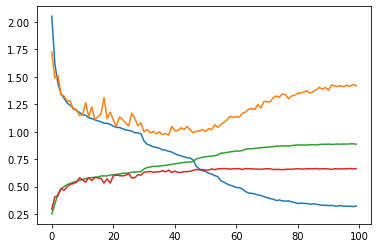

In [9]:
import pickle
pickle.dump(hist, open('vgg16bn_wo_tf_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [8]:
model_path = './vgg16_wo_tf.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7674496173858643 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 1.898 | Avg.acc: 0.246


- Avg. val_loss: 1.811 | Avg. val_acc: 0.249


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.6478954553604126 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 1.799 | Avg.acc: 0.258


- Avg. val_loss: 1.697 | Avg. val_acc: 0.301


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.915024995803833 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.679 | Avg.acc: 0.312



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.669 | Avg. val_acc: 0.290
Epoch:  4


Loss=1.691045880317688 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.590 | Avg.acc: 0.359


- Avg. val_loss: 1.509 | Avg. val_acc: 0.411


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.5652985572814941 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 1.516 | Avg.acc: 0.395



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.506 | Avg. val_acc: 0.406
Epoch:  6


Loss=1.3105641603469849 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 1.452 | Avg.acc: 0.425


- Avg. val_loss: 1.361 | Avg. val_acc: 0.459


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.5899852514266968 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 1.400 | Avg.acc: 0.446


- Avg. val_loss: 1.373 | Avg. val_acc: 0.467


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.2888474464416504 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.352 | Avg.acc: 0.476


- Avg. val_loss: 1.267 | Avg. val_acc: 0.515


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.5201497077941895 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.315 | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.254 | Avg. val_acc: 0.515
Epoch:  10


Loss=1.321250081062317 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.277 | Avg.acc: 0.501


- Avg. val_loss: 1.202 | Avg. val_acc: 0.533


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.2899682521820068 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.248 | Avg.acc: 0.518


- Avg. val_loss: 1.187 | Avg. val_acc: 0.542


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.1404162645339966 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 1.228 | Avg.acc: 0.526


- Avg. val_loss: 1.169 | Avg. val_acc: 0.551


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.051892638206482 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.209 | Avg.acc: 0.534


- Avg. val_loss: 1.162 | Avg. val_acc: 0.554


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.1454883813858032 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.198 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193 | Avg. val_acc: 0.544
Epoch:  15


Loss=1.0969922542572021 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 1.184 | Avg.acc: 0.542


- Avg. val_loss: 1.160 | Avg. val_acc: 0.559


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.0076617002487183 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 1.174 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.559
Epoch:  17


Loss=1.079196572303772 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.160 | Avg.acc: 0.556


- Avg. val_loss: 1.139 | Avg. val_acc: 0.568


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.09010910987854 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 1.149 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.143 | Avg. val_acc: 0.561
Epoch:  19


Loss=0.8805803656578064 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.133 | Avg.acc: 0.569


- Avg. val_loss: 1.120 | Avg. val_acc: 0.574


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.1182119846343994 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 1.133 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.555
Epoch:  21


Loss=1.3700361251831055 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.122 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.572
Epoch:  22


Loss=1.2140803337097168 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 1.106 | Avg.acc: 0.577


- Avg. val_loss: 1.118 | Avg. val_acc: 0.579


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=1.0814921855926514 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.095 | Avg.acc: 0.584


- Avg. val_loss: 1.093 | Avg. val_acc: 0.591


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.9028133749961853 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 1.093 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.575
Epoch:  25


Loss=1.2655757665634155 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.077 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.579
Epoch:  26


Loss=1.146407127380371 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.072 | Avg.acc: 0.595


- Avg. val_loss: 1.074 | Avg. val_acc: 0.597


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.2182835340499878 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.062 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.583
Epoch:  28


Loss=1.2552180290222168 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 1.049 | Avg.acc: 0.607


- Avg. val_loss: 1.062 | Avg. val_acc: 0.605


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.3459175825119019 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 1.044 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.597
Epoch:  30


Loss=1.0405466556549072 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.034 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.600
Epoch:  31


Loss=1.1051533222198486 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.026 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.596
Epoch:  32


Loss=1.2222574949264526 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.014 | Avg.acc: 0.621


- Avg. val_loss: 1.062 | Avg. val_acc: 0.605


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.2019805908203125 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.008 | Avg.acc: 0.627


- Avg. val_loss: 1.055 | Avg. val_acc: 0.614


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.0564124584197998 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.009 | Avg.acc: 0.622


- Avg. val_loss: 1.034 | Avg. val_acc: 0.615


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=1.0510849952697754 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 0.996 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.612
Epoch:  36


Loss=1.0915882587432861 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.993 | Avg.acc: 0.629


- Avg. val_loss: 1.022 | Avg. val_acc: 0.624


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=1.1852755546569824 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.977 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.619
Epoch:  38


Loss=0.7060447335243225 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.977 | Avg.acc: 0.635


- Avg. val_loss: 1.035 | Avg. val_acc: 0.627


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=1.1962833404541016 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.968 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.609
Epoch:  40


Loss=1.142371654510498 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.962 | Avg.acc: 0.639


- Avg. val_loss: 1.022 | Avg. val_acc: 0.632


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=1.0127054452896118 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.958 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.623
Epoch:  42


Loss=0.908159613609314 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.952 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.625
Epoch:  43


Loss=0.793022871017456 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.944 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.622
Epoch:  44


Loss=0.6988423466682434 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.940 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.619
Epoch:  45


Loss=1.1266613006591797 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.932 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.620
Epoch:  46


Loss=1.2799427509307861 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.926 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.622
Epoch:  47


Loss=0.9027964472770691 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.919 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.622
Epoch:  48


Loss=0.8150531053543091 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.922 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.617
Epoch    48: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  49


Loss=0.6287575364112854 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.867 | Avg.acc: 0.679


- Avg. val_loss: 1.015 | Avg. val_acc: 0.636


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.8039852380752563 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]

- Avg.loss: 0.850 | Avg.acc: 0.685


- Avg. val_loss: 1.011 | Avg. val_acc: 0.637


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  51


Loss=0.9809762835502625 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.836 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.632
Epoch:  52


Loss=1.055599570274353 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.832 | Avg.acc: 0.690


- Avg. val_loss: 1.031 | Avg. val_acc: 0.641


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  53


Loss=1.2200480699539185 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.827 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.631
Epoch:  54


Loss=0.758323073387146 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.814 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.637
Epoch:  55


Loss=0.6246504783630371 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.809 | Avg.acc: 0.701


- Avg. val_loss: 1.011 | Avg. val_acc: 0.645


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=0.5529356598854065 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]

- Avg.loss: 0.807 | Avg.acc: 0.702


- Avg. val_loss: 1.020 | Avg. val_acc: 0.647


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  57


Loss=0.8349258303642273 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.799 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.643
Epoch:  58


Loss=0.9917763471603394 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s]

- Avg.loss: 0.798 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.646
Epoch:  59


Loss=0.6490095853805542 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.789 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.636
Epoch:  60


Loss=0.9523696899414062 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.779 | Avg.acc: 0.712


- Avg. val_loss: 1.040 | Avg. val_acc: 0.648


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=0.7677367925643921 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.778 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.643
Epoch:  62


Loss=0.8673375248908997 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.774 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.641
Epoch:  63


Loss=0.6252030730247498 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.770 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.639
Epoch    63: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  64


Loss=0.905131459236145 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.732 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.647
Epoch:  65


Loss=0.6554843187332153 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.719 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.645
Epoch:  66


Loss=0.6707696914672852 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.704 | Avg.acc: 0.743


- Avg. val_loss: 1.035 | Avg. val_acc: 0.649


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  67


Loss=0.8349746465682983 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.706 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.645
Epoch:  68


Loss=0.6995094418525696 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.701 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.648
Epoch:  69


Loss=0.8742017149925232 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.693 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.641
Epoch:  70


Loss=0.8850336074829102 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.696 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.645
Epoch:  71


Loss=0.7857534289360046 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.683 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.644
Epoch    71: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  72


Loss=0.6506044268608093 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.659 | Avg.acc: 0.761


- Avg. val_loss: 1.055 | Avg. val_acc: 0.651


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  73


Loss=0.9177175760269165 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.658 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.648
Epoch:  74


Loss=0.730530321598053 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.649 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.651
Epoch:  75


Loss=0.6532876491546631 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.644 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.643
Epoch:  76


Loss=0.4104081094264984 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.648 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.651
Epoch:  77


Loss=1.1526315212249756 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.640 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.649
Epoch:  78


Loss=0.6788354516029358 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.642 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.651
Epoch:  79


Loss=0.9904266595840454 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.631 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.646
Epoch    79: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  80


Loss=0.3356000781059265 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.628 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.648
Epoch:  81


Loss=0.5544052720069885 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.614 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.650
Epoch:  82


Loss=1.0240408182144165 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.617 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.650
Epoch:  83


Loss=0.6529577374458313 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.616 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.650
Epoch:  84


Loss=0.4146694242954254 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.609 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.645
Epoch:  85


Loss=0.3867402672767639 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.611 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.644
Epoch:  86


Loss=0.5837277173995972 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.600 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.647
Epoch:  87


Loss=0.5308985114097595 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.605 | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.649
Epoch    87: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  88


Loss=0.45010459423065186 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.599 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.649
Epoch:  89


Loss=0.4403899312019348 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.594 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.651
Epoch:  90


Loss=0.5845534205436707 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.594 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.649
Epoch:  91


Loss=0.5681338310241699 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s]

- Avg.loss: 0.596 | Avg.acc: 0.785



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.649
Epoch:  92


Loss=0.6265538930892944 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.594 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.649
Epoch:  93


Loss=0.27121174335479736 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.591 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.647
Epoch:  94


Loss=0.8332196474075317 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.595 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.651
Epoch:  95


Loss=0.5787091255187988 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.583 | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.647
Epoch:  97


Loss=0.4292382597923279 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.584 | Avg.acc: 0.790



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.650
Epoch:  98


Loss=0.7858120203018188 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.586 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.648
Epoch:  99


Loss=0.5491007566452026 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.585 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.650
Epoch:  100


Loss=0.6171873211860657 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.578 | Avg.acc: 0.792


- Avg. val_loss: 1.100 | Avg. val_acc: 0.647
Finished Training


([<matplotlib.lines.Line2D at 0x7f9124668160>,
 0.6514349400947339)

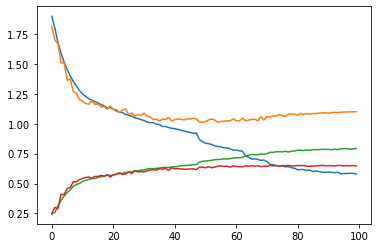

In [9]:
import pickle
pickle.dump(hist, open('vgg16_wo_tf_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [8]:
test_model = torch.load('vgg16_bn_wo_tf.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.047 | Avg. val_acc: 0.675


In [10]:
test_model = torch.load('vgg16_wo_tf.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.002 | Avg. val_acc: 0.656


## ResNeXt 50

In [6]:
from torchvision.models import resnext50_32x4d
model = resnext50_32x4d(pretrained=False)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=2048, out_features=7, bias=True)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [7]:
device = torch.device('cuda')
model = model.to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './resnext50_wo_tf.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8360403776168823 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:39<00:00,  5.65it/s]

- Avg.loss: 2.014 | Avg.acc: 0.262



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.703 | Avg. val_acc: 0.302
* Update optimal model
Epoch:  2


Loss=1.6812708377838135 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.607 | Avg.acc: 0.363


- Avg. val_loss: 1.503 | Avg. val_acc: 0.420


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.4293614625930786 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.470 | Avg.acc: 0.430


- Avg. val_loss: 1.428 | Avg. val_acc: 0.458


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.4753960371017456 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.389 | Avg.acc: 0.466


- Avg. val_loss: 1.345 | Avg. val_acc: 0.486


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.3298075199127197 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.62it/s]

- Avg.loss: 1.337 | Avg.acc: 0.488


- Avg. val_loss: 1.294 | Avg. val_acc: 0.505


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.199554204940796 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.300 | Avg.acc: 0.506


- Avg. val_loss: 1.300 | Avg. val_acc: 0.507


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2504253387451172 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.278 | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.501
Epoch:  8


Loss=1.3934062719345093 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:39<00:00,  5.63it/s]

- Avg.loss: 1.261 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.329 | Avg. val_acc: 0.501
Epoch:  9


Loss=0.9251200556755066 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.249 | Avg.acc: 0.526


- Avg. val_loss: 1.244 | Avg. val_acc: 0.532


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.244410753250122 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:39<00:00,  5.63it/s]

- Avg.loss: 1.242 | Avg.acc: 0.527


- Avg. val_loss: 1.216 | Avg. val_acc: 0.542


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.3352724313735962 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.220 | Avg.acc: 0.537


- Avg. val_loss: 1.209 | Avg. val_acc: 0.545


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.2327375411987305 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.218 | Avg.acc: 0.539


- Avg. val_loss: 1.166 | Avg. val_acc: 0.555


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.2094340324401855 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.208 | Avg.acc: 0.543



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204 | Avg. val_acc: 0.550
Epoch:  14


Loss=1.1278194189071655 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.203 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.245 | Avg. val_acc: 0.538
Epoch:  15


Loss=0.8921985030174255 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 1.198 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.202 | Avg. val_acc: 0.546
Epoch:  16


Loss=1.2918660640716553 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.192 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.271 | Avg. val_acc: 0.528
Epoch:  17


Loss=1.2699207067489624 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.54it/s]

- Avg.loss: 1.181 | Avg.acc: 0.552


- Avg. val_loss: 1.152 | Avg. val_acc: 0.563


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.0209177732467651 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.182 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.551
Epoch:  19


Loss=1.3722909688949585 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.177 | Avg.acc: 0.552


- Avg. val_loss: 1.154 | Avg. val_acc: 0.565


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.5551892518997192 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.172 | Avg.acc: 0.555


- Avg. val_loss: 1.124 | Avg. val_acc: 0.577


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.9744365811347961 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:39<00:00,  5.64it/s]

- Avg.loss: 1.166 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.558
Epoch:  22


Loss=1.1092844009399414 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.161 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.564
Epoch:  23


Loss=1.1864097118377686 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.159 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.565
Epoch:  24


Loss=1.3921589851379395 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.53it/s]

- Avg.loss: 1.149 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.558
Epoch:  25


Loss=1.0840682983398438 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.146 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.553
Epoch:  26


Loss=1.2731577157974243 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.145 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.575
Epoch:  27


Loss=1.2928391695022583 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.144 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.573
Epoch:  28


Loss=1.3647805452346802 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.135 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.563
Epoch    28: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  29


Loss=1.0129244327545166 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.078 | Avg.acc: 0.592


- Avg. val_loss: 1.070 | Avg. val_acc: 0.596


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.095669150352478 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.062 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.593
Epoch:  31


Loss=1.2324421405792236 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.059 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.596
Epoch:  32


Loss=1.1642053127288818 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.046 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.595
Epoch:  33


Loss=1.0134235620498657 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.045 | Avg.acc: 0.604


- Avg. val_loss: 1.076 | Avg. val_acc: 0.605


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=0.888771653175354 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.039 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.587
Epoch:  35


Loss=0.9987272024154663 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.032 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.598
Epoch:  36


Loss=0.8587704300880432 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:39<00:00,  5.65it/s]

- Avg.loss: 1.030 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.586
Epoch:  37


Loss=1.1129662990570068 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.027 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.603
Epoch    37: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  38


Loss=0.8985192775726318 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.979 | Avg.acc: 0.629


- Avg. val_loss: 1.034 | Avg. val_acc: 0.614


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=0.7567470669746399 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.968 | Avg.acc: 0.635


- Avg. val_loss: 1.030 | Avg. val_acc: 0.616


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=0.8827158212661743 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.960 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.614
Epoch:  41


Loss=1.128862738609314 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.955 | Avg.acc: 0.641


- Avg. val_loss: 1.028 | Avg. val_acc: 0.619


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.9764507412910461 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.947 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.618
Epoch:  43


Loss=0.9676696062088013 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.937 | Avg.acc: 0.647


- Avg. val_loss: 1.023 | Avg. val_acc: 0.622


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Loss=0.9738829135894775 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.931 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.621
Epoch:  45


Loss=0.8859584927558899 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.931 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.617
Epoch:  46


Loss=0.8132950067520142 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.926 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.617
Epoch:  47


Loss=0.8990673422813416 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.919 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.616
Epoch:  48


Loss=0.8743909597396851 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.919 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.610
Epoch:  49


Loss=0.9253982305526733 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.910 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.619
Epoch:  50


Loss=0.8534299731254578 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.905 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.614
Epoch:  51


Loss=0.6018857955932617 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.901 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.615
Epoch:  52


Loss=0.983974039554596 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:39<00:00,  5.64it/s]

- Avg.loss: 0.898 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.617
Epoch    52: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  53


Loss=0.90247642993927 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.62it/s]

- Avg.loss: 0.863 | Avg.acc: 0.677


- Avg. val_loss: 1.015 | Avg. val_acc: 0.627


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  54


Loss=1.0022739171981812 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.852 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.626
Epoch:  55


Loss=0.9561606645584106 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.62it/s]

- Avg.loss: 0.849 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.616
Epoch:  56


Loss=1.1859558820724487 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.837 | Avg.acc: 0.690


- Avg. val_loss: 1.021 | Avg. val_acc: 0.629


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  57


Loss=0.9455567598342896 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.830 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.623
Epoch:  58


Loss=0.9635002613067627 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.825 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.624
Epoch:  59


Loss=1.0437740087509155 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.822 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.622
Epoch:  60


Loss=1.0022108554840088 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.55it/s]

- Avg.loss: 0.815 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.628
Epoch    60: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  61


Loss=0.550937831401825 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.797 | Avg.acc: 0.704


- Avg. val_loss: 1.021 | Avg. val_acc: 0.636


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  62


Loss=0.6145937442779541 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.786 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.631
Epoch:  63


Loss=1.3092114925384521 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.783 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.632
Epoch:  64


Loss=0.7729939222335815 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.775 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.626
Epoch:  65


Loss=0.7653493285179138 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.771 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.631
Epoch:  66


Loss=0.9517409801483154 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.770 | Avg.acc: 0.712


- Avg. val_loss: 1.035 | Avg. val_acc: 0.637


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  67


Loss=1.0742226839065552 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.757 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.637
Epoch:  68


Loss=0.8025104403495789 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.757 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.632
Epoch    68: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  69


Loss=0.7481939196586609 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.741 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.636
Epoch:  70


Loss=0.8551367521286011 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.735 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.633
Epoch:  71


Loss=0.6865217089653015 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.737 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.636
Epoch:  72


Loss=0.8553766012191772 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.729 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.630
Epoch:  73


Loss=0.7383542060852051 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.730 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.634
Epoch:  74


Loss=0.8547114729881287 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.719 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.636
Epoch:  75


Loss=0.6147584915161133 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.62it/s]

- Avg.loss: 0.726 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.634
Epoch:  76


Loss=0.8764702081680298 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:39<00:00,  5.66it/s]

- Avg.loss: 0.722 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.632
Epoch    76: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  77


Loss=0.612167239189148 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:40<00:00,  5.55it/s]

- Avg.loss: 0.705 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.633
Epoch:  78


Loss=0.7123302817344666 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.706 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.632
Epoch:  79


Loss=0.547578752040863 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.710 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.635
Epoch:  80


Loss=0.6429115533828735 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.707 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.627
Epoch:  81


Loss=0.6882318258285522 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.704 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.631
Epoch:  82


Loss=0.9276864528656006 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.696 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.637
Epoch:  83


Loss=0.7382577061653137 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.699 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.634
Epoch:  84


Loss=0.7831395864486694 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.700 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.634
Epoch    84: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  85


Loss=0.9935998916625977 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.691 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.634
Epoch:  86


Loss=0.4432351887226105 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:40<00:00,  5.55it/s]

- Avg.loss: 0.692 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.637
Epoch:  87


Loss=0.5254080295562744 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.690 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.637
Epoch:  88


Loss=0.6458759307861328 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.687 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.636
Epoch:  89


Loss=0.7869645357131958 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.688 | Avg.acc: 0.746


- Avg. val_loss: 1.061 | Avg. val_acc: 0.639


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  90


Loss=0.6441347599029541 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.691 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.634
Epoch:  91


Loss=0.5909938216209412 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.691 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.635
Epoch:  92


Loss=0.5762208700180054 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.685 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.636
Epoch    92: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  93


Loss=0.9909024834632874 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.691 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.636
Epoch:  94


Loss=0.6493748426437378 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.54it/s]

- Avg.loss: 0.676 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.635
Epoch:  95


Loss=0.6953781843185425 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.688 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.634
Epoch:  96


Loss=0.6754566431045532 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.685 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.637
Epoch:  97


Loss=0.817524790763855 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.63it/s]

- Avg.loss: 0.686 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.637
Epoch:  98


Loss=0.6281129717826843 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.679 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.636
Epoch:  99


Loss=0.669223427772522 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.678 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.638
Epoch:  100


Loss=0.6504054665565491 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.677 | Avg.acc: 0.751


- Avg. val_loss: 1.076 | Avg. val_acc: 0.638
Epoch   100: reducing learning rate of group 0 to 7.8125e-06.
Finished Training


([<matplotlib.lines.Line2D at 0x7f714c646ac8>,
 0.6388966285873502)

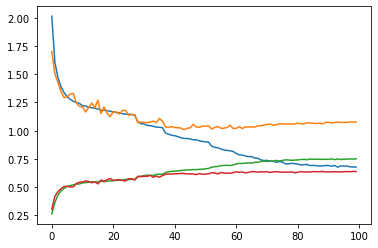

In [9]:
import pickle
pickle.dump(hist, open('resnext50_wo_tf_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [10]:
test_model = torch.load('resnext50_wo_tf.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.027 | Avg. val_acc: 0.644


## Densenet 161

In [5]:
from torchvision.models import densenet161

model = densenet161(pretrained=False)
model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier = nn.Linear(in_features=2208, out_features=7, bias=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [6]:
device = torch.device('cuda')
model = model.to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [7]:
model_path = './densenet161_wo_tf.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=2.5234060287475586 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [01:07<00:00,  3.34it/s]

- Avg.loss: 2.012 | Avg.acc: 0.246



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 10.401 | Avg. val_acc: 0.242
* Update optimal model
Epoch:  2


Loss=1.6353296041488647 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:07<00:00,  3.32it/s]

- Avg.loss: 1.863 | Avg.acc: 0.247


- Avg. val_loss: 1.828 | Avg. val_acc: 0.258


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.6270761489868164 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.802 | Avg.acc: 0.270


- Avg. val_loss: 1.715 | Avg. val_acc: 0.319


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.6839362382888794 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:08<00:00,  3.31it/s]

- Avg.loss: 1.693 | Avg.acc: 0.332


- Avg. val_loss: 1.573 | Avg. val_acc: 0.386


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.3926275968551636 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.410 | Avg.acc: 0.454



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.472 | Avg. val_acc: 0.429
Epoch:  8


Loss=1.670779824256897 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.357 | Avg.acc: 0.478


- Avg. val_loss: 1.376 | Avg. val_acc: 0.479


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.415908694267273 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.318 | Avg.acc: 0.492



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.472 | Avg. val_acc: 0.443
Epoch:  10


Loss=1.4490253925323486 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.291 | Avg.acc: 0.505


- Avg. val_loss: 1.276 | Avg. val_acc: 0.520


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.4206218719482422 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.272 | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.418 | Avg. val_acc: 0.460
Epoch:  12


Loss=0.9616267085075378 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.249 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.368 | Avg. val_acc: 0.481
Epoch:  13


Loss=1.2686588764190674 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.235 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.512
Epoch:  14


Loss=1.073628306388855 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.233 | Avg.acc: 0.529


- Avg. val_loss: 1.227 | Avg. val_acc: 0.541


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.2503894567489624 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.206 | Avg.acc: 0.542


- Avg. val_loss: 1.214 | Avg. val_acc: 0.542


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.0761005878448486 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.202 | Avg.acc: 0.541


- Avg. val_loss: 1.185 | Avg. val_acc: 0.544


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.9134824872016907 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.190 | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.235 | Avg. val_acc: 0.534
Epoch:  18


Loss=1.1946967840194702 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.182 | Avg.acc: 0.551


- Avg. val_loss: 1.180 | Avg. val_acc: 0.548


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.2771981954574585 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:07<00:00,  3.32it/s]

- Avg.loss: 1.175 | Avg.acc: 0.549


- Avg. val_loss: 1.153 | Avg. val_acc: 0.562


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.3775932788848877 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:07<00:00,  3.33it/s]

- Avg.loss: 1.166 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.519
Epoch:  21


Loss=1.2396503686904907 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.160 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.548
Epoch:  22


Loss=1.1189082860946655 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:08<00:00,  3.31it/s]

- Avg.loss: 1.157 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200 | Avg. val_acc: 0.540
Epoch:  23


Loss=1.2714320421218872 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.145 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.549
Epoch:  24


Loss=1.1106418371200562 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.139 | Avg.acc: 0.566


- Avg. val_loss: 1.125 | Avg. val_acc: 0.569


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.341557264328003 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:08<00:00,  3.31it/s]

- Avg.loss: 1.135 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.228 | Avg. val_acc: 0.535
Epoch:  26


Loss=1.0891090631484985 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.136 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.568
Epoch:  27


Loss=1.0757707357406616 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.130 | Avg.acc: 0.569


- Avg. val_loss: 1.114 | Avg. val_acc: 0.581


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.9363923072814941 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.123 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.566
Epoch:  29


Loss=0.8791071176528931 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:08<00:00,  3.27it/s]

- Avg.loss: 1.126 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.561
Epoch:  30


Loss=1.091891884803772 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.117 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.574
Epoch:  31


Loss=1.0364856719970703 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.120 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.576
Epoch:  32


Loss=1.213117003440857 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.112 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.560
Epoch:  33


Loss=1.1430213451385498 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.110 | Avg.acc: 0.578


- Avg. val_loss: 1.105 | Avg. val_acc: 0.585


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.1738529205322266 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.102 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.573
Epoch:  35


Loss=1.0396937131881714 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.106 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.263 | Avg. val_acc: 0.532
Epoch:  36


Loss=1.6552587747573853 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.101 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.582
Epoch:  37


Loss=0.8984808921813965 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.091 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138 | Avg. val_acc: 0.573
Epoch:  38


Loss=0.8860162496566772 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.098 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.574
Epoch:  39


Loss=1.2853376865386963 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.089 | Avg.acc: 0.584


- Avg. val_loss: 1.102 | Avg. val_acc: 0.593


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=0.9149994850158691 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 1.089 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.141 | Avg. val_acc: 0.580
Epoch:  41


Loss=1.036718487739563 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.089 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.578
Epoch:  42


Loss=1.236799716949463 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:07<00:00,  3.33it/s]

- Avg.loss: 1.085 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.566
Epoch:  43


Loss=0.7154355049133301 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.084 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.556
Epoch:  44


Loss=1.1999801397323608 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:08<00:00,  3.31it/s]

- Avg.loss: 1.086 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.585
Epoch:  45


Loss=1.6055415868759155 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.078 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.589
Epoch:  46


Loss=1.2563905715942383 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.076 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.580
Epoch:  47


Loss=1.321213960647583 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.076 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.564
Epoch:  48


Loss=1.2755391597747803 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:08<00:00,  3.28it/s]

- Avg.loss: 1.074 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.579
Epoch:  49


Loss=0.9442259073257446 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.068 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.587
Epoch:  50


Loss=0.9554388523101807 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.069 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.587
Epoch:  51


Loss=1.4095896482467651 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 1.067 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.583
Epoch:  52


Loss=1.4716047048568726 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 1.070 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.583
Epoch:  53


Loss=1.0957462787628174 Batch_id=54 Accuracy=0.5703125:  24%|██▍       | 54/225 [00:18<00:52,  3.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.1322928667068481 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 0.948 | Avg.acc: 0.642


- Avg. val_loss: 1.023 | Avg. val_acc: 0.627


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  72


Loss=1.0655597448349 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 0.933 | Avg.acc: 0.647


- Avg. val_loss: 1.023 | Avg. val_acc: 0.628


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  73


Loss=1.0507111549377441 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 0.935 | Avg.acc: 0.648


- Avg. val_loss: 1.006 | Avg. val_acc: 0.635


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  74


Loss=0.754365086555481 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:07<00:00,  3.32it/s]

- Avg.loss: 0.928 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.621
Epoch:  75


Loss=0.8233102560043335 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:07<00:00,  3.32it/s]

- Avg.loss: 0.926 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.622
Epoch:  76


Loss=0.7785084843635559 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.628
Epoch:  77


Loss=1.07791268825531 Batch_id=217 Accuracy=0.6171875:  96%|█████████▋| 217/225 [01:05<00:02,  3.60it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0060663223266602 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 0.851 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.631
Epoch:  96


Loss=0.9583046436309814 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.30it/s]

- Avg.loss: 0.847 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.629
Epoch:  97


Loss=0.9711816310882568 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 0.851 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.634
Epoch    97: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  98


Loss=0.8067898154258728 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 0.847 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.634
Epoch:  99


Loss=1.138627290725708 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:08<00:00,  3.29it/s]

- Avg.loss: 0.846 | Avg.acc: 0.682


- Avg. val_loss: 1.010 | Avg. val_acc: 0.637


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  100


Loss=0.9556779861450195 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:07<00:00,  3.31it/s]

- Avg.loss: 0.842 | Avg.acc: 0.685


- Avg. val_loss: 1.012 | Avg. val_acc: 0.632
Finished Training


([<matplotlib.lines.Line2D at 0x7f6ba25bef28>,
 0.6369462245750905)

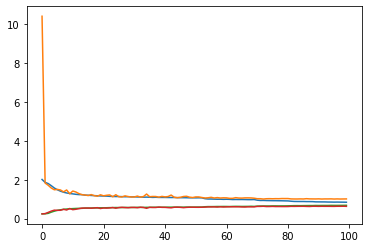

In [12]:
import pickle
pickle.dump(hist, open('densenet161_wo_tf_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [13]:
test_model = torch.load('densenet161_wo_tf.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.990 | Avg. val_acc: 0.632


## v3.4 (VGG16bn backbone)

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(64)
        self.bn0b = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn1b = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2c = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn3b = nn.BatchNorm2d(512)
        self.bn3c = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.bn4c = nn.BatchNorm2d(512)
  
        self.fact0 = FeatureAct(64, 4)
        self.fact1 = FeatureAct(128, 4)
        self.fact2 = FeatureAct(256, 4)
        self.fact3 = FeatureAct(512, 4)
        self.fact4 = FeatureAct(512, 4)
        
        # 2x64, 2x128, 3x256, 3x512, 3x512
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(7,7)),
                                        nn.Flatten(),
                                        nn.Linear(in_features=25088, out_features=4096, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=4096, out_features=4096, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=4096, out_features=7, bias=True))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        x = self.conv2c(x)
        x = self.bn2c(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        x = self.conv3c(x)
        x = self.bn3c(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = self.conv4(x3)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv4b(x)
        x = self.bn4b(x)
        x = self.relu(x)
        x = self.conv4c(x)
        x = self.bn4c(x)
        x = self.relu(x)
        
        x4 = self.maxpool(x)
        x4 = self.fact4(x4)
        
        x = self.classifier(x4)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './v34_vgg16bn_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7481237649917603 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 2.098 | Avg.acc: 0.242


- Avg. val_loss: 1.841 | Avg. val_acc: 0.249


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.8026354312896729 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.759 | Avg.acc: 0.279


- Avg. val_loss: 1.790 | Avg. val_acc: 0.271


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.4461357593536377 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.626 | Avg.acc: 0.345


- Avg. val_loss: 1.588 | Avg. val_acc: 0.388


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.516658067703247 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.485 | Avg.acc: 0.411


- Avg. val_loss: 1.446 | Avg. val_acc: 0.432


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.4867281913757324 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.421 | Avg.acc: 0.439


- Avg. val_loss: 1.350 | Avg. val_acc: 0.475


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.481177568435669 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.387 | Avg.acc: 0.458



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.524 | Avg. val_acc: 0.431
Epoch:  7


Loss=1.181518316268921 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.350 | Avg.acc: 0.473


- Avg. val_loss: 1.291 | Avg. val_acc: 0.507


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.4280136823654175 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.303 | Avg.acc: 0.499



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.629 | Avg. val_acc: 0.437
Epoch:  9


Loss=1.0980974435806274 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.277 | Avg.acc: 0.509


- Avg. val_loss: 1.225 | Avg. val_acc: 0.528


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.0818558931350708 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.248 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.527
Epoch:  11


Loss=1.4220796823501587 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.227 | Avg.acc: 0.533


- Avg. val_loss: 1.179 | Avg. val_acc: 0.543


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.0263887643814087 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.209 | Avg.acc: 0.536


- Avg. val_loss: 1.171 | Avg. val_acc: 0.553


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.1699613332748413 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.190 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.551
Epoch:  14


Loss=1.048730492591858 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.181 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.548
Epoch:  15


Loss=1.1450763940811157 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.166 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.553
Epoch:  16


Loss=0.9596796631813049 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.160 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193 | Avg. val_acc: 0.549
Epoch:  17


Loss=1.0418373346328735 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.148 | Avg.acc: 0.568


- Avg. val_loss: 1.146 | Avg. val_acc: 0.567


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.2873424291610718 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.133 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.265 | Avg. val_acc: 0.535
Epoch:  19


Loss=1.0234013795852661 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.136 | Avg.acc: 0.573


- Avg. val_loss: 1.108 | Avg. val_acc: 0.583


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.1028889417648315 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.123 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192 | Avg. val_acc: 0.562
Epoch:  21


Loss=0.8985845446586609 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.111 | Avg.acc: 0.586


- Avg. val_loss: 1.103 | Avg. val_acc: 0.588


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.2856838703155518 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.097 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.585
Epoch:  23


Loss=0.8954496383666992 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.096 | Avg.acc: 0.594


- Avg. val_loss: 1.081 | Avg. val_acc: 0.601


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.9348872303962708 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.082 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.182 | Avg. val_acc: 0.567
Epoch:  25


Loss=1.0251071453094482 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.076 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.584
Epoch:  26


Loss=1.2024005651474 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.066 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.594
Epoch:  27


Loss=0.9523543119430542 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.061 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.600
Epoch:  28


Loss=1.1459532976150513 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.047 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.574
Epoch:  29


Loss=1.2367531061172485 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.047 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.586
Epoch:  30


Loss=0.9467027187347412 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.037 | Avg.acc: 0.613


- Avg. val_loss: 1.128 | Avg. val_acc: 0.602


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=1.1322818994522095 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.027 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.896 | Avg. val_acc: 0.546
Epoch:  32


Loss=1.0781567096710205 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 1.011 | Avg.acc: 0.627


- Avg. val_loss: 1.070 | Avg. val_acc: 0.609


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.1271233558654785 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.997 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.608
Epoch:  34


Loss=0.7705990672111511 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.999 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.604
Epoch:  35


Loss=1.0121898651123047 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:56<00:00,  1.28it/s]

- Avg.loss: 0.986 | Avg.acc: 0.636


- Avg. val_loss: 1.045 | Avg. val_acc: 0.610


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=0.8462156057357788 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.981 | Avg.acc: 0.637


- Avg. val_loss: 1.036 | Avg. val_acc: 0.616


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=1.155499815940857 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.971 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.613
Epoch:  38


Loss=0.9854833483695984 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.956 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.614
Epoch:  39


Loss=1.123569130897522 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.961 | Avg.acc: 0.646


- Avg. val_loss: 1.018 | Avg. val_acc: 0.628


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=0.9264931678771973 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.948 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.607
Epoch:  41


Loss=0.9894400835037231 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.937 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.620
Epoch:  42


Loss=0.9892039895057678 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.935 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.290 | Avg. val_acc: 0.567
Epoch:  43


Loss=1.2001787424087524 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.926 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.600
Epoch:  44


Loss=0.9542376399040222 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.923 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.628
Epoch:  45


Loss=0.8191865682601929 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.915 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.626
Epoch:  46


Loss=1.0775082111358643 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.902 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.619
Epoch:  47


Loss=0.9046542048454285 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.893 | Avg.acc: 0.673


- Avg. val_loss: 1.022 | Avg. val_acc: 0.628


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  48


Loss=0.8271700143814087 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.892 | Avg.acc: 0.673


- Avg. val_loss: 0.999 | Avg. val_acc: 0.631


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=1.1489890813827515 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.881 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.625
Epoch:  50


Loss=0.797400951385498 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.872 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.612
Epoch:  51


Loss=1.0067343711853027 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.867 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.629
Epoch:  52


Loss=0.873022735118866 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.861 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.604
Epoch:  53


Loss=0.8921369314193726 Batch_id=16 Accuracy=0.6796875:   7%|▋         | 16/225 [00:15<02:43,  1.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6784664988517761 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.743 | Avg.acc: 0.731


- Avg. val_loss: 0.977 | Avg. val_acc: 0.650


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=0.9776239395141602 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.724 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.647
Epoch:  60


Loss=0.6161641478538513 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.721 | Avg.acc: 0.742


- Avg. val_loss: 1.011 | Avg. val_acc: 0.653


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=0.5740666389465332 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.703 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.646
Epoch:  62


Loss=0.6089948415756226 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.696 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.648
Epoch:  63


Loss=0.7555258870124817 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.690 | Avg.acc: 0.752


- Avg. val_loss: 1.026 | Avg. val_acc: 0.656


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  64


Loss=0.6677595973014832 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.676 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.636
Epoch:  65


Loss=0.5927596092224121 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:56<00:00,  1.28it/s]

- Avg.loss: 0.667 | Avg.acc: 0.763


- Avg. val_loss: 1.043 | Avg. val_acc: 0.657


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  66


Loss=0.7808859944343567 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.656 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.652
Epoch    66: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  67


Loss=0.43174004554748535 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.616 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.656
Epoch:  68


Loss=0.7448983788490295 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.586 | Avg.acc: 0.791


- Avg. val_loss: 1.060 | Avg. val_acc: 0.658


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  69


Loss=0.5842110514640808 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.580 | Avg.acc: 0.793


- Avg. val_loss: 1.092 | Avg. val_acc: 0.659


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  70


Loss=0.45311397314071655 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.571 | Avg.acc: 0.798



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.654
Epoch:  71


Loss=0.4839724004268646 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.557 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.654
Epoch:  72


Loss=0.7856726050376892 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.553 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.651
Epoch:  73


Loss=0.43438488245010376 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.540 | Avg.acc: 0.809



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.658
Epoch:  74


Loss=0.5269742608070374 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.529 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.659
Epoch    74: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  75


Loss=0.38633984327316284 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.504 | Avg.acc: 0.823


- Avg. val_loss: 1.137 | Avg. val_acc: 0.660


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  76


Loss=0.35981693863868713 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.494 | Avg.acc: 0.825


- Avg. val_loss: 1.167 | Avg. val_acc: 0.664


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  77


Loss=0.6257615685462952 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.485 | Avg.acc: 0.830



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.662
Epoch:  78


Loss=0.3719790279865265 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [02:55<00:00,  1.28it/s]

- Avg.loss: 0.378 | Avg.acc: 0.869


- Avg. val_loss: 1.342 | Avg. val_acc: 0.657
Finished Training


([<matplotlib.lines.Line2D at 0x7ffaf5557fd0>,
 0.6636946224575091)

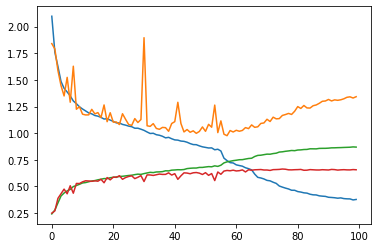

In [10]:
import pickle
pickle.dump(hist, open('v34_vgg16bn_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [8]:
test_model = torch.load('v34_vgg16bn_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.092 | Avg. val_acc: 0.670


## Number of trainable parameters

In [21]:
from torchvision import models

our_optimal_params = 1886141

vgg16 = torch.load('vgg16_wo_tf.pt')
vgg16_bn = torch.load('vgg16_bn_wo_tf.pt') 
resnet50 = torch.load('resnet50_wo_tf.pt')
resnext50 =  torch.load('resnext50_wo_tf.pt')
densenet161 = torch.load('densenet161_wo_tf.pt')

vgg16_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
vgg16_bn_params = sum(p.numel() for p in vgg16_bn.parameters() if p.requires_grad)
resnet50_params = sum(p.numel() for p in resnet50.parameters() if p.requires_grad)
resnext50_params = sum(p.numel() for p in resnext50.parameters() if p.requires_grad)
densenet161_params = sum(p.numel() for p in densenet161.parameters() if p.requires_grad)

our_optimal_params, vgg16_params, vgg16_bn_params, resnet50_params, resnext50_params, densenet161_params

(1886141, 134288071, 134296519, 23516103, 22987975, 26478055)

In [36]:
vgg16_bn

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256